In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [2]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

In [3]:
import numpy as np
import seaborn as sns
import os

In [4]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
from moe_models import cross_entropy_loss
from moe_expectation_model import moe_expectation_model

device cpu


In [8]:
dataset = 'fashion_mnist_all_10000'

In [9]:
#transform = tv.transforms.Compose()
trainset = tv.datasets.FashionMNIST('data', transform=tv.transforms.ToTensor(), train=True)
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
testset = tv.datasets.FashionMNIST('data',transform=tv.transforms.ToTensor(), train=False)
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [120]:
batchsize=128

In [149]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=True, num_workers=1, pin_memory=True)


In [152]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18), classes=10):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = nrows*ncols
    print(n_images)
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    for index in range(n_images):
        ax[index].imshow( images_to_plot[index,:,:,:]) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[index].axis('off')  
        if titles is not None and index<classes:
            ax[index].set_title(titles[index%classes])

10


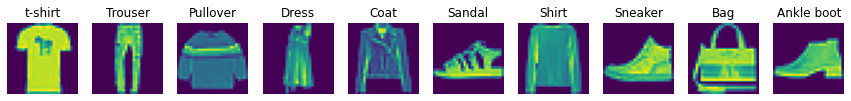

In [153]:
# Display 10 samples from each of the 10 classes in Fashion Mnist dataset
classes = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle boot']
images_to_plot = None
i = 0
for data , labels in trainloader:
    index = np.where(labels==i)[0]
    if len(index) >= 10:
        if i == 0:
            images_to_plot = data[index[0:10],:,:]
        else:
            images_to_plot = np.vstack((images_to_plot, data[index[0:10],:,:]))
        i += 1
images_to_plot = images_to_plot.reshape(10,10,28, 28, 1).transpose(1,0,2,3,4).reshape(100,28,28,1)
plot_colour_images(images_to_plot, nrows=1, ncols=10,thefigsize=(15,15), titles=classes)
plt.savefig(os.path.join('figures/review', dataset+'_images.png'))

In [148]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=train_size,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)


In [58]:
palette = [plt.get_cmap('tab20')(i) for i in range(20)]
palette.pop(6)
palette.pop(6)

(1.0, 0.596078431372549, 0.5882352941176471, 1.0)

In [59]:
len(palette)

18

In [61]:
def colors(p,  palette=['y','g','r','c','b','tab:pink','tab:brown','tab:cyan','tab:olive','tab:purple']):
    uniq_y = np.unique(p)
    pred_color = [palette[i] for i in uniq_y]
    return pred_color

In [62]:
def pca_tsne_plot(X, y, classes, dataset, size, filter_class=False):
    transformer = IncrementalPCA(n_components=50, batch_size=128)
    if filter_class:
        index = filter_classes(classes_sub, size)
    else:
        index = list(range(0,size))
    X_pca = transformer.fit_transform(X.reshape(X.shape[0],X.shape[-1]*X.shape[-1]))
    X_pca = X_pca[index]
    print('X:',X.shape)
    y = y[index]
    print(np.unique(y, return_counts=True))
    print('PCA:',X_pca.shape)
    print('y:', y.shape)
    X_embedded = TSNE(n_components=2,perplexity=50.0,).fit_transform(X_pca)
    print('TSNE:',X_embedded.shape)    
    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))
    true_label_names = [classes[i] for i in y]
    true_color = colors(y, palette[0:len(classes)]) 
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=true_label_names, hue_order=classes, palette=true_color, ax=ax)
    plt.savefig('figures/fashion_mnist/'+dataset+'.png')
    return X_pca, X_embedded
    

In [63]:
classes = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle boot']

X: torch.Size([10000, 1, 28, 28])
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 942, 1027, 1016, 1019,  974,  989, 1021, 1022,  990, 1000]))
PCA: (10000, 50)
y: torch.Size([10000])
TSNE: (10000, 2)


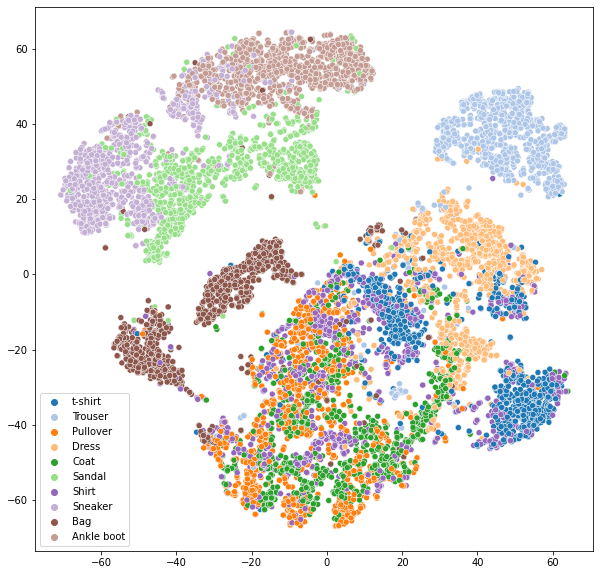

In [65]:
size = 10000
for X, y in trainloader:
    X_pca, X_tsne = pca_tsne_plot(X, y, classes, dataset, size)

In [11]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self, output):
        super(expert_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=10)

        self.out = nn.Linear(in_features=10, out_features=output)


    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        #print('CONV T SHAPE', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print('MAX POOL T SHAPE', t.shape)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t


In [17]:
#Expert network
class expert_layers_presoftmax(nn.Module):
    def __init__(self, output):
        super(expert_layers_presoftmax, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=15)
        self.fc2 = nn.Linear(in_features=15, out_features=30)

        self.out = nn.Linear(in_features=30, out_features=output)


    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        print(t.shape)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        
        return t


In [12]:
# create a set of experts
def experts(num_experts, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [19]:
#Expert network
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes, T=1.0):
        super(gate_layers, self).__init__()
        # define layers
        self.fc1 = nn.Linear(in_features=28*28, out_features=15)
        self.fc2 = nn.Linear(in_features=15, out_features=30)
        self.out = nn.Linear(in_features=30, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0
        self.T = T


    def forward(self, t):
        t = torch.flatten(t, start_dim=2).reshape(t.shape[0], t.shape[2]*t.shape[3])

        # fc1      
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/self.T, dim=1)
        return t


In [13]:
#Expert network
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [14]:
# compute
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [15]:
batchsize = 128

In [16]:
total_experts = 5

In [17]:
num_classes = 10

In [18]:
num_epochs = 30

In [19]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=batchsize,
                                          shuffle=True, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=True, num_workers=1)

In [23]:
# experiment with models with different number of experts
w_importance=0.0
w_ortho = 0.0
w_ideal_gate = 0.0

augment = False
attention = False
T_max = 1
#T_decay = T_max/num_epochs
#T_decay = T_max/(num_epochs - T_decay_start)
T_decay = 0
T_decay_start = 0

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if T_decay > 0:
        plot_file += '_Tdecay_'+str(T_decay)
    if T_decay_start > 0:
        plot_file += '_Tdecaystart_'+str(T_decay_start)
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    if augment:
        plot_file += '_augment'
    if attention:
        plot_file += '_attention'
    plot_file += '_'+specific
    
    return plot_file


In [156]:
expert = expert_layers(num_classes)
params = [p.numel() for p in expert.parameters() if p.requires_grad]
sum(params)

921

In [24]:
models = {#'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss,'experts':{}}, 
          'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}}, 
          #'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}}
         }
for T in range(1, T_max+1):
    print('Temperature', T)
    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models = experts(num_experts, expert_layers_presoftmax)
            else:
                expert_models = experts(num_experts)
            gate_model = gate_layers(num_experts, num_classes)
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.001, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.001, momentum=0.9)
            hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
            plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
            torch.save(models,open(os.path.join('results/review', plot_file),'wb'))

    models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}}, 
      #'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}}
     }

                

Temperature 1
Model: moe_expectation_model
Number of experts  5
model params: 5471
epoch 0 training loss 1.19 , training accuracy 0.56 , test accuracy 0.67
epoch 1 training loss 0.73 , training accuracy 0.73 , test accuracy 0.76
epoch 2 training loss 0.63 , training accuracy 0.78 , test accuracy 0.77
epoch 3 training loss 0.58 , training accuracy 0.80 , test accuracy 0.79
epoch 4 training loss 0.55 , training accuracy 0.80 , test accuracy 0.81
epoch 5 training loss 0.52 , training accuracy 0.82 , test accuracy 0.80
epoch 6 training loss 0.51 , training accuracy 0.82 , test accuracy 0.81
epoch 7 training loss 0.50 , training accuracy 0.82 , test accuracy 0.80
epoch 8 training loss 0.49 , training accuracy 0.82 , test accuracy 0.81
epoch 9 training loss 0.47 , training accuracy 0.83 , test accuracy 0.81
epoch 10 training loss 0.46 , training accuracy 0.84 , test accuracy 0.80
epoch 11 training loss 0.47 , training accuracy 0.83 , test accuracy 0.82
epoch 12 training loss 0.45 , training 

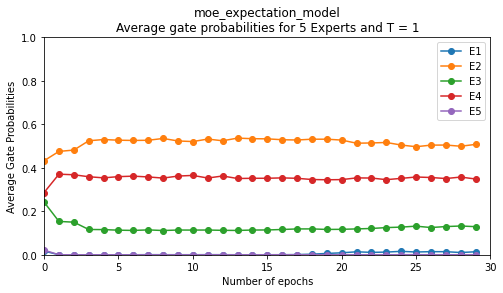

In [25]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset,'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join('results/review', plot_file))
    
    for m_key, m_val in models.items():
        for i in range(total_experts, total_experts+1):
            history = m_val['experts'][i]['history']
            plt.plot(range(len(history['gate_probability'])), history['gate_probability'], marker='o')
        legend_labels = ['E'+str(i) for i in range(1, total_experts+1)]
        plt.title(m_key+'\n'+'Average gate probabilities for ' + str(i) + ' Experts and T = '+str(T))
        plt.legend(legend_labels)
        plt.xlabel('Number of epochs')
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1)
        plt.ylabel('Average Gate Probabilities')
        image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join('figures/review', 'gate_prob_'+image_file))
        plt.show()


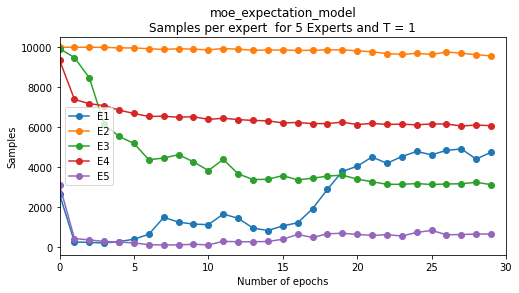

In [26]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join('results/review', plot_file))

    for m_key, m_val in models.items():
        for i in range(total_experts, total_experts+1):
            history = m_val['experts'][i]['history']
            plt.plot(range(len(history['exp_samples'])), history['exp_samples'], marker='o')

        legend_labels = ['E'+str(i) for i in range(1, total_experts+1)]
        plt.title(m_key+'\n'+'Samples per expert  for ' + str(i) + ' Experts and T = '+str(T))
        plt.legend(legend_labels)
        plt.xlabel('Number of epochs')
        plt.xlim(0, num_epochs)
        plt.xlim(0, num_epochs)
        plt.ylabel('Samples')
        image_file = generate_plot_file(dataset+'_'+m_key, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join('figures/review', 'samples_'+image_file))

        plt.show()
    

(10, 20)


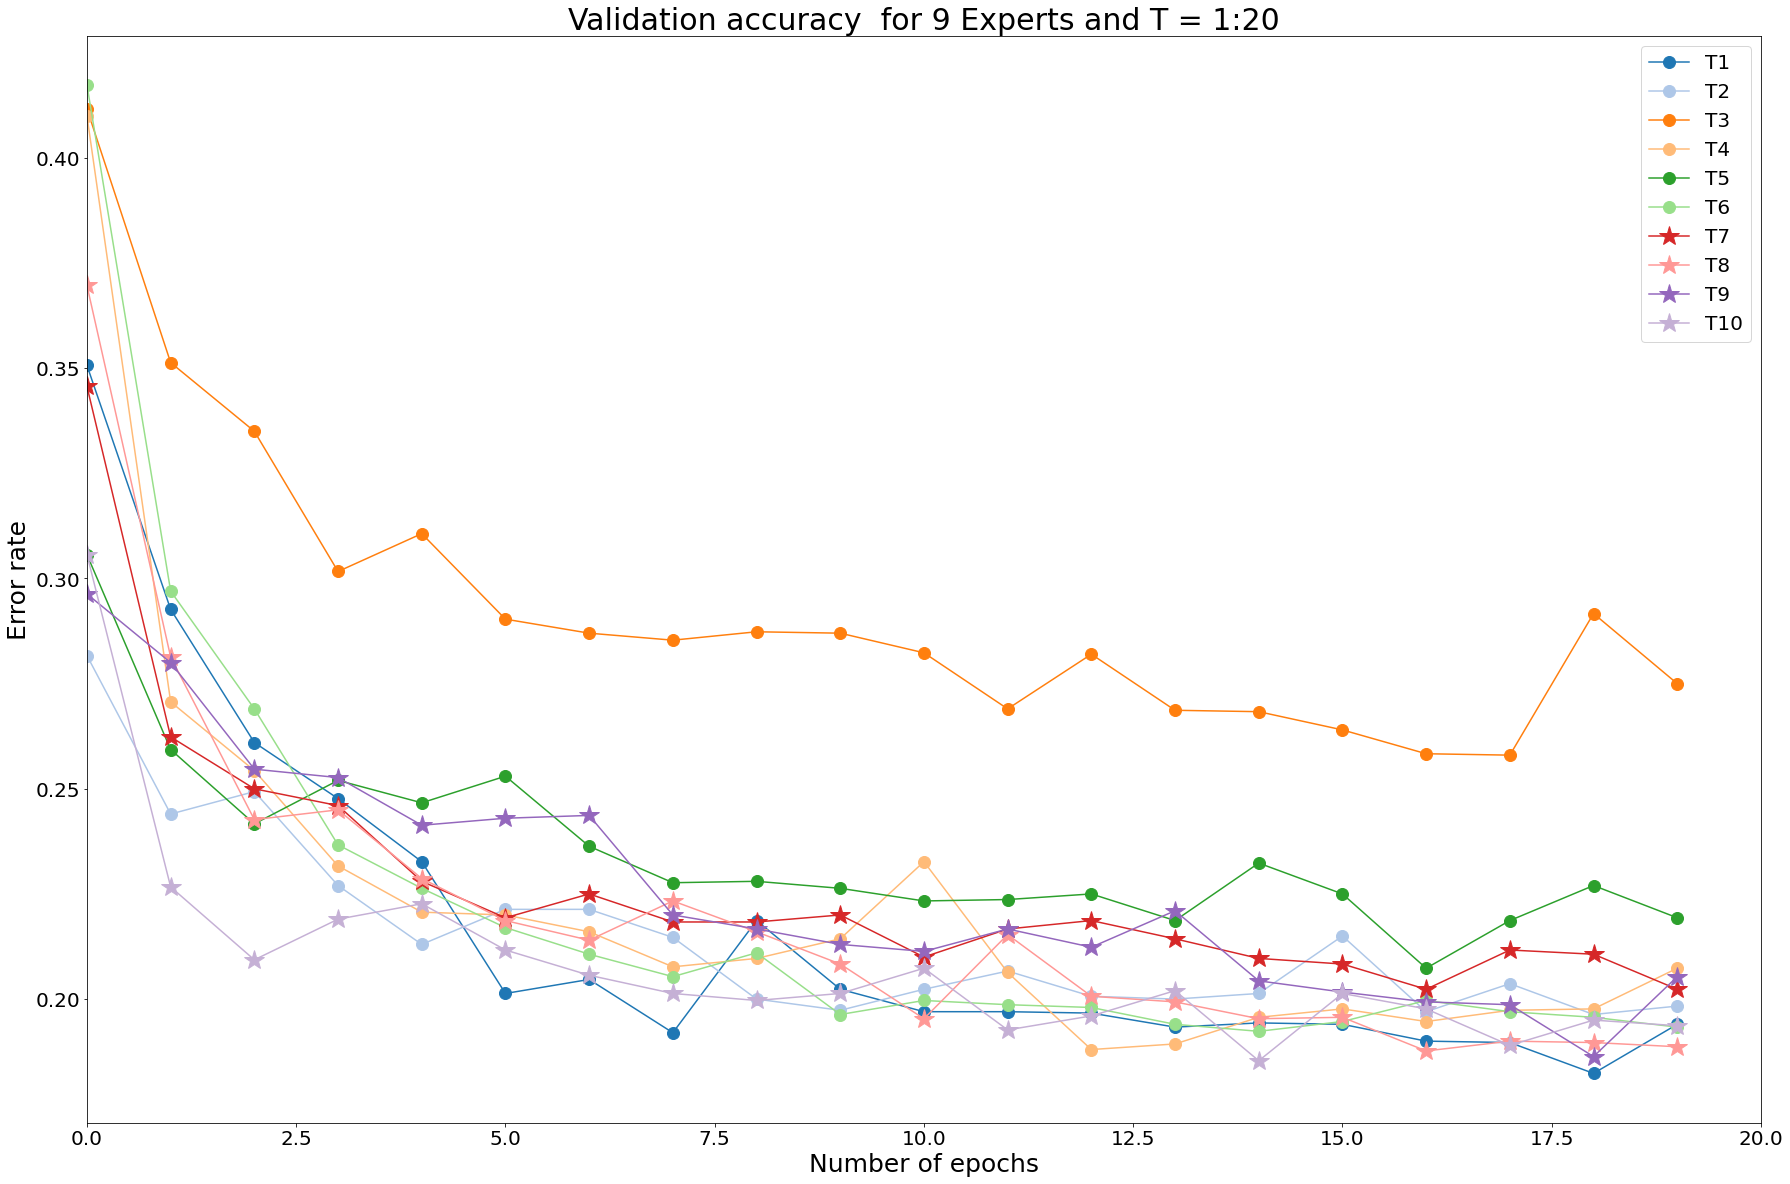

In [33]:
val_accuracies = []

legend_labels = []

start = 0

for T in range(1, T_max+1):
    models = torch.load(os.path.join('results/', dataset+'_T_'+str(T)+'_'+str(num_classes)+'_model.pt'))
    for m_key, m_val in models.items():
        for i in range(total_experts, total_experts+1):
            history = m_val['experts'][i]['history']
            val_accuracies.append((1-np.asarray(history['val_accuracy']))[start:])

    legend_labels.append('T'+str(T))
val_accuracies = np.asarray(val_accuracies)
print(val_accuracies.shape)

plt.rcParams["figure.figsize"] = (30,20)

for i in range(len(val_accuracies)):
    if i > 5:
        marker = '*'
        markersize = 20
    else:
        marker = 'o'
        markersize = 12
    plt.plot(range(start, num_epochs), val_accuracies[i], color=palette[i], marker=marker, markersize=markersize)

plt.title('Validation accuracy  for ' + str(i) + ' Experts and T = 1:20', fontsize=30)
plt.legend(legend_labels, prop={'size': 20})
plt.xlabel('Number of epochs', fontsize=25)
plt.xlim(start, num_epochs)
plt.ylabel('Error rate',  fontsize=25)
plt.tick_params(labelsize=20)
plt.ion()
plt.isinteractive
plt.savefig(os.path.join('figures', 'val_accuracy_'+dataset+'_'+str(num_classes)+'_'+str(total_experts)+'_part_experts.png'))
plt.show()
    

Mutual information for  moe_expectation_model


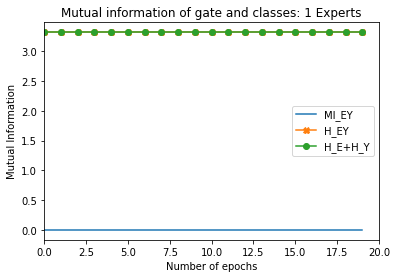

Mutual information for  moe_expectation_model


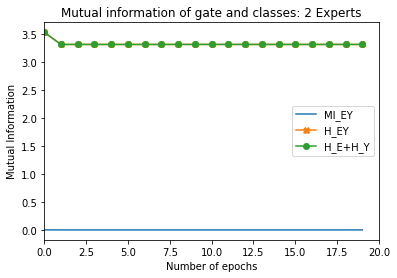

Mutual information for  moe_expectation_model


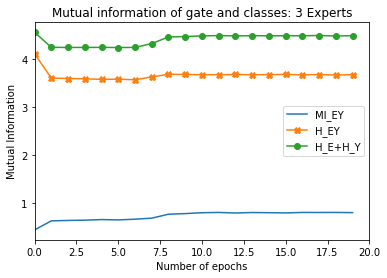

Mutual information for  moe_expectation_model


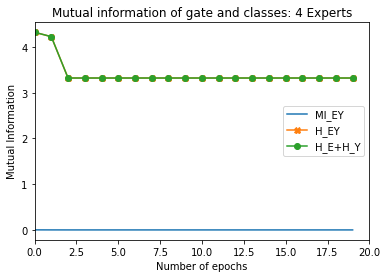

Mutual information for  moe_expectation_model


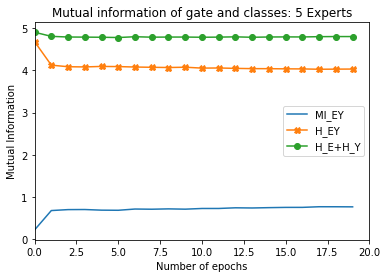

Mutual information for  moe_expectation_model


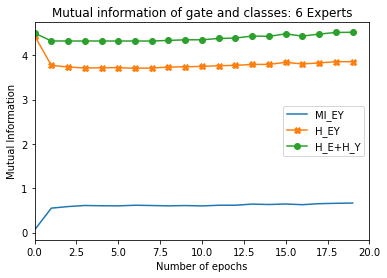

Mutual information for  moe_expectation_model


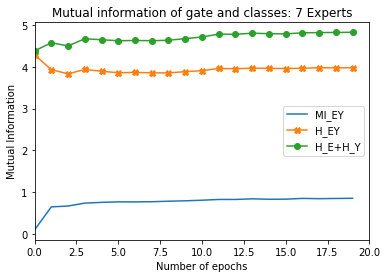

Mutual information for  moe_expectation_model


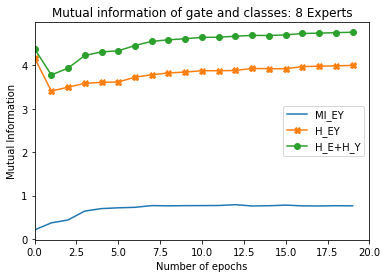

Mutual information for  moe_expectation_model


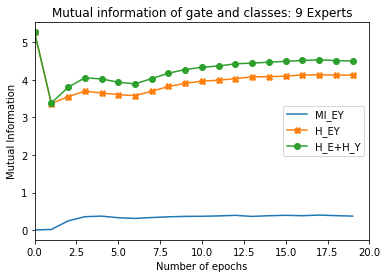

Mutual information for  moe_expectation_model


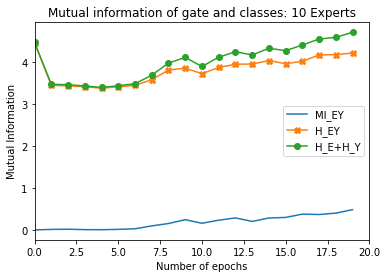

In [115]:
for i in range(1, total_experts+1):
    legend_labels = []
    for m_key, m_val in models.items():
        print('Mutual information for ', m_key)
        history = m_val['experts'][i]['history']
#         print('EY', history['EY'][-1], '\n\n')
#         print('Mutual_EY', history['mutual_EY'], '\n\n')
#         print('H_EY', history['H_EY'], '\n\n')
#         print('H_E', history['H_E'], '\n\n')
#         print('H_Y', history['H_Y'], '\n\n')

        plt.plot(range(len(history['mutual_EY'])), history['mutual_EY'])
        plt.plot(range(len(history['H_EY'])), history['H_EY'],marker='X')
        plt.plot(range(len(history['H_Y'])), 
                 [history['H_E'][i] + history['H_Y'][i] for i in range(len(history['H_Y']))], marker='o')
        
        legend_labels = ['MI_EY']
        legend_labels += ['H_EY']
        legend_labels += ['H_E+H_Y']
                 
        plt.title('Mutual information of gate and classes: ' + str(i) + ' Experts')
        plt.legend(legend_labels)
        plt.xlabel('Number of epochs')
        plt.xlim(0, num_epochs)
        plt.ylabel('Mutual Information')
        #plt.ylim(0, 1)
        plt.savefig('figures/all/mutual_information_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.show()

In [33]:
def get_labels(p):
    pred_labels = torch.argmax(p, dim=1)
    return pred_labels

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict(dataloader, model):
        
        pred_labels = []
        true_labels = []
        for i, data in enumerate(dataloader):
            inputs, labels = data
            true_labels.append(labels)
            pred_labels.append(torch.argmax(model(inputs), dim=1))
            
        return torch.stack(true_labels), torch.stack(pred_labels)

In [35]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=train_size,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

Number of Experts: 5
Temperature 1
torch.Size([10000, 5, 10])


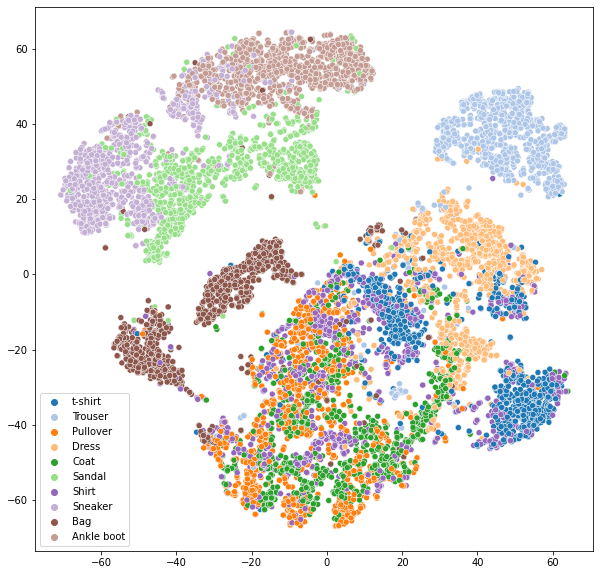

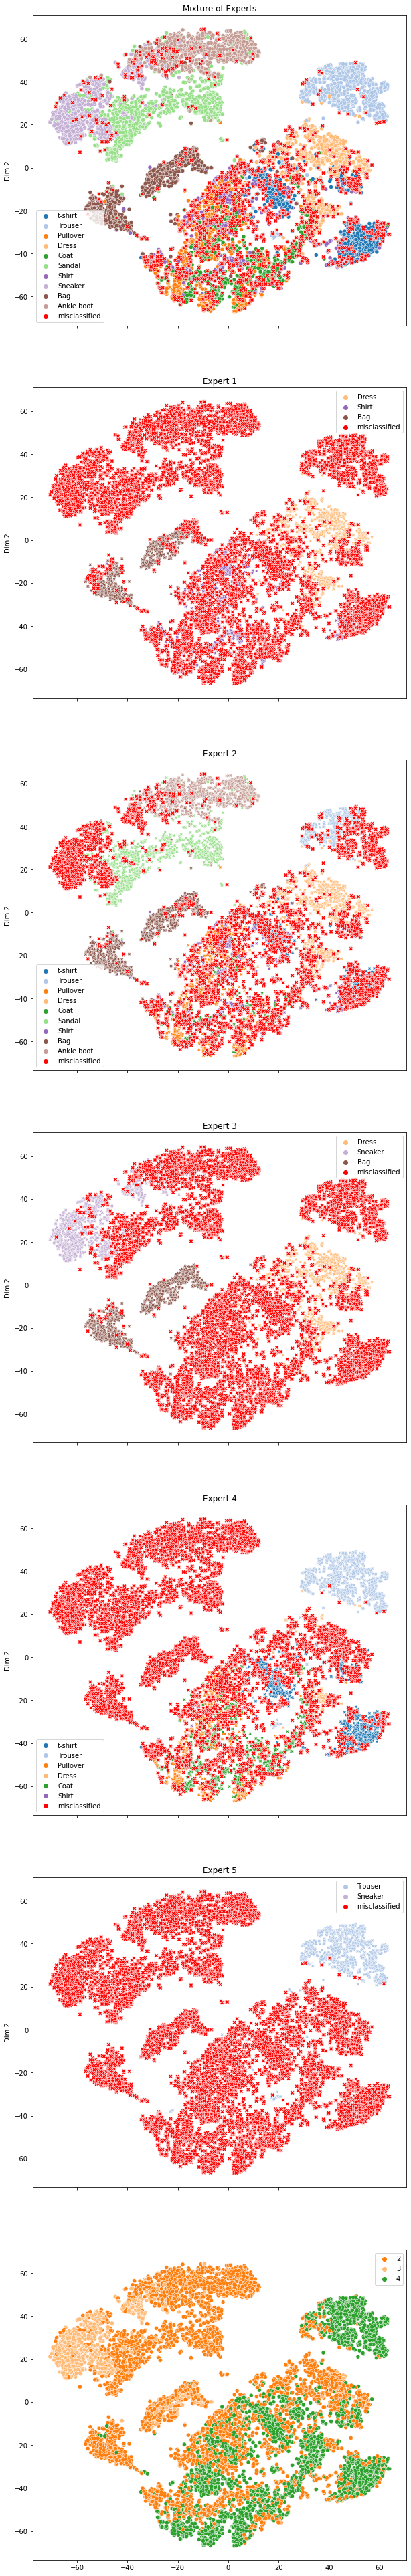

In [66]:
for T in range(1, T_max+1):

    plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join('results/review', plot_file))

    keys = models.keys()
    N = len(keys)

    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

    for X, y in trainloader:
        true_label_names = [classes[i] for i in y]
        true_color = colors(y, palette[0:num_classes]) 
        sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                        hue=true_label_names, hue_order=classes, palette=true_color,ax=ax)

    for e in range(total_experts, total_experts+1):
        nrows = 2+e
        ncols = N
        thefigsize = (ncols*10,nrows*10)

        print('Number of Experts:', e)
        print('Temperature', str(T))

        fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
        ax = ax.flatten()


        index = 0
        for X, y in trainloader:
            for m_key, m_val in models.items():

                moe_model = m_val['experts'][e]['model']

                pred = moe_model(X)
                pred_labels = get_labels(pred)
                pred_label_names = [classes[i] for i in pred_labels]
                pred_color = colors(pred_labels, palette[0:num_classes])
                pred_classes = [classes[i] for i in np.unique(pred_labels)]

                true_label_names = [classes[i] for i in y]
                true_color = colors(y, palette[0:num_classes]) 

                sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                                hue=pred_label_names,hue_order=pred_classes,palette=pred_color, ax=ax[index])
                indices = np.where((pred_labels == y) == False)[0]
                sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[index])

                ax[index].set_title('Mixture of Experts')
                ax[index].set_ylabel('Dim 2')
                ax[index].set_xlabel('Dim 1')


                print(moe_model.expert_outputs.shape)
                for i in range(e):
                    pred_expert_labels = get_labels(moe_model.expert_outputs[:,i,:])

                    indices = np.where((pred_expert_labels == y) == True)[0]

                    pred_expert_label_names = [classes[i] for i in pred_expert_labels[indices]]
                    pred_expert_color = colors(pred_expert_labels[indices], palette[0:num_classes])
                    pred_expert_classes = [classes[i] for i in np.unique(pred_expert_labels[indices])]
                    sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=pred_expert_label_names,hue_order=pred_expert_classes,palette=pred_expert_color,marker='X', s=20,alpha=1.0, ax=ax[N*(i+1)+index])
                    indices = np.where((pred_expert_labels == y) == False)[0]
                    sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[N*(i+1)+index])

                    ax[N*(i+1)+index].set_title('Expert '+str(i+1))
                    ax[N*(i+1)+index].set_ylabel('Dim 2')
                    ax[N*(i+1)+index].set_xlabel('Dim 1')

                pred_gate = moe_model.gate_outputs
                pred_gate_labels = get_labels(pred_gate)+1
                pred_gate_color = colors(pred_gate_labels, palette)

                sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                                hue=pred_gate_labels,hue_order=np.unique(pred_gate_labels),palette=pred_gate_color, ax=ax[N*(e+1)+index])       

                index += 1
        image_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes))
        filename = os.path.join('figures/review', image_file+'_'+str(e)+'_experts.png')
        plt.savefig(filename)
        plt.show()
    


In [ ]:
for i in range(1, total_experts+1):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['entropy'])), history['entropy'])
        legend_labels.append(m_key)
    plt.title('Average entropy: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Avg Entropy')
    #plt.ylim(0, 1)
    plt.savefig('figures/all/entropy_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [ ]:
for i in range(1, total_experts+1):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['loss_importance'])), history['loss_importance'])
        legend_labels.append(m_key)
    plt.title('Loss Importance: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Loss')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/loss_importance_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [ ]:
for i in range(1, total_experts+1):
    
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['loss'])), history['loss'])
        legend_labels.append(m_key)
    plt.title('Loss: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Loss')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/loss_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [ ]:
for i in range(1, total_experts+1):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['accuracy'])), 1-np.asarray(history['accuracy']))
        legend_labels.append(m_key)
    plt.title('Error rate: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.ylabel('Training Error Rate')
#     plt.ylim(0, 1)
    plt.savefig('figures/all/accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [ ]:
for i in range(1, total_experts+1):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['val_accuracy'])), 1-np.asarray(history['val_accuracy']))
        legend_labels.append(m_key)
    plt.title('Error rate: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(1, num_epochs+1)
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.savefig('figures/all/val_accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [87]:
num_classes

10

In [108]:
#Expert network
class single_model_layers(nn.Module):
    def __init__(self, output):
        super(single_model_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        self.count = 0

    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        return t


In [70]:
#Expert network
class single_model_layers(nn.Module):
    def __init__(self, output):
        super(single_model_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=25)
        self.fc2 = nn.Linear(in_features=25, out_features=50)
        self.out = nn.Linear(in_features=50, out_features=num_classes)
        self.count = 0

    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        return t


In [109]:
single_model = single_model_layers(num_classes)
single_model_type = 'simple'

In [110]:
params = [p.numel() for p in single_model.parameters() if p.requires_grad]
print('model params:', sum(params))

model params: 921


In [111]:
single_model_optimizer = optim.RMSprop(single_model.parameters(),
                                      lr=0.001, momentum=0.9)

In [112]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=batchsize,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

In [113]:
single_model_history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
for epoch in range(0, num_epochs):
    running_loss = 0.0
    training_accuracy = 0.0
    test_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, y = data

        # zero the parameter gradients
        single_model_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = single_model(X)
        loss = cross_entropy_loss(outputs, y)
        loss.backward()
        single_model_optimizer.step()
        
        running_loss += loss.item()
        training_accuracy += accuracy(outputs, y)
        
    for j, test_data in enumerate(testloader, 0):
        test_input, test_labels = test_data
        test_outputs = single_model(test_input)
        test_accuracy += accuracy(test_outputs, test_labels)
    single_model_history['loss'].append(running_loss/(i+1))
    single_model_history['accuracy'].append(training_accuracy/(i+1))
    single_model_history['val_accuracy'].append(test_accuracy/(j+1))
    print('epoch: %d loss: %.2f training accuracy: %.2f val accuracy: %.2f' %
            (epoch + 1, running_loss / (i+1), training_accuracy/(i+1), test_accuracy/(j+1)))
    
torch.save({'model':single_model,'history':single_model_history},open(os.path.join('results/review', dataset+'_single_'+single_model_type+'_model.pt'),'wb'))

print('Finished Training')

epoch: 1 loss: 1.21 training accuracy: 0.52 val accuracy: 0.63
epoch: 2 loss: 0.76 training accuracy: 0.71 val accuracy: 0.72
epoch: 3 loss: 0.67 training accuracy: 0.75 val accuracy: 0.74
epoch: 4 loss: 0.63 training accuracy: 0.76 val accuracy: 0.76
epoch: 5 loss: 0.60 training accuracy: 0.77 val accuracy: 0.77
epoch: 6 loss: 0.58 training accuracy: 0.78 val accuracy: 0.77
epoch: 7 loss: 0.57 training accuracy: 0.78 val accuracy: 0.77
epoch: 8 loss: 0.55 training accuracy: 0.79 val accuracy: 0.78
epoch: 9 loss: 0.55 training accuracy: 0.79 val accuracy: 0.79
epoch: 10 loss: 0.54 training accuracy: 0.80 val accuracy: 0.79
epoch: 11 loss: 0.53 training accuracy: 0.80 val accuracy: 0.79
epoch: 12 loss: 0.53 training accuracy: 0.80 val accuracy: 0.80
epoch: 13 loss: 0.52 training accuracy: 0.80 val accuracy: 0.80
epoch: 14 loss: 0.52 training accuracy: 0.81 val accuracy: 0.80
epoch: 15 loss: 0.51 training accuracy: 0.81 val accuracy: 0.80
epoch: 16 loss: 0.51 training accuracy: 0.81 val 

In [99]:
torch.save({'model':single_model,'history':single_model_history},open(os.path.join('results/review', dataset+'_single_'+single_model_type+'_model.pt'),'wb'))

In [114]:
train_size = 10000
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,list(range(0,train_size))), 
                                          batch_size=train_size,
                                          shuffle=False, num_workers=1)
test_size = 3000
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset,list(range(0,test_size))),
                                         batch_size=test_size,
                                         shuffle=False, num_workers=1)

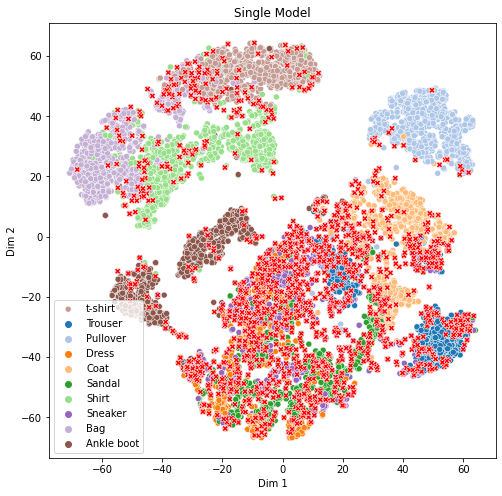

In [115]:
fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,8))
single_model_info = torch.load(os.path.join('results/review', dataset+'_single_'+single_model_type+'_model.pt'))
single_model = single_model_info['model']
for X, y in trainloader:
    pred = single_model(X)
    pred_labels = get_labels(pred)
    pred_label_names = [classes[i] for i in pred_labels]
    pred_color = colors(pred_labels, palette[0:num_classes])
    pred_classes = [classes[i] for i in np.unique(pred_labels)]
        
    sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                            hue=pred_label_names,hue_order=pred_classes,palette=pred_color, ax=ax)
    indices = np.where((pred_labels == y) == False)[0]
    sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                            hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax)
    
    ax.set_title('Single Model')
    ax.set_ylabel('Dim 2')
    ax.set_xlabel('Dim 1')
    ax.legend(classes)
    plt.savefig(os.path.join('figures/review', dataset+'single_'+single_model_type+'_network.png'))

tensor(0.7990)
tensor(0.8133)


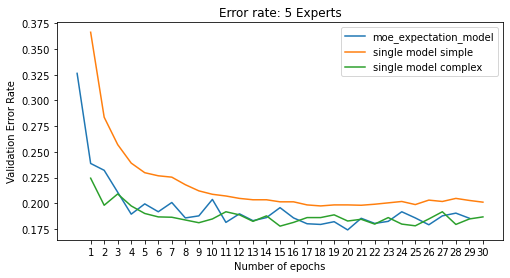

In [157]:
for i in range(total_experts, total_experts+1):
    plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_model.pt')
    models = torch.load(os.path.join('results/review', plot_file))

    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['val_accuracy'])), 1-np.asarray(history['val_accuracy']))
        legend_labels.append(m_key)

    single_model_info = torch.load(os.path.join('results/review', dataset+'_single_simple_model.pt'))
    history = single_model_info['history']
    print(history['val_accuracy'][-1])
    plt.plot(range(1,len(history['val_accuracy'])+1), 1-np.asarray(history['val_accuracy']))
    legend_labels.append('single model simple')
    
    single_model_info = torch.load(os.path.join('results/review', dataset+'_single_complex_model.pt'))
    history = single_model_info['history']
    print(history['val_accuracy'][-1])
    plt.plot(range(1,len(history['val_accuracy'])+1), 1-np.asarray(history['val_accuracy']))
    legend_labels.append('single model complex')


    plt.title('Error rate: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.ylabel('Validation Error Rate')
    plt.xticks(np.arange(1, num_epochs+1, step=1))
    plt.savefig('figures/review/val_accuracy_'+dataset+'_single_'+single_model_type+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()